# Topic modelling of Bundestag speeches

Dataset from https://opendiscourse.de/

> Richter, F.; Koch, P.; Franke, O.; Kraus, J.; Kuruc, F.; Thiem, A.; Högerl, J.; Heine, S.; Schöps, K. (2020). Open Discourse. https://doi.org/10.7910/DVN/FIKIBO. Harvard Dataverse. V3.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import re
import spacy
# from spacy.lang.de.stop_words import STOP_WORDS as STOP_WORDS_DE

In [3]:
import pyarrow.feather as feather
import json

In [4]:
from IPython.display import clear_output

In [5]:
plt.rcParams['figure.figsize'] = (14,5)

## Load Data

*Data in feather format https://arrow.apache.org/docs/python/feather.html*

In [6]:
speeches_df = feather.read_feather('data/opendiscourse/feather/speeches.feather')
fractions_df = feather.read_feather('data/opendiscourse/feather/factions.feather')
#contributions_df = feather.read_feather('data/opendiscourse/feather/contributions_extended.feather')

## Prepare Data

In [7]:
#fractions_df.replace(to_replace='not found', value=np.nan, inplace=True)
fractions_df.rename(columns={'abbreviation':'fraction', 'fullName':'fractionFullName'}, inplace=True)

In [8]:
fractions_df.head()

,id,fraction,fractionFullName
0,-1,not found,not found
1,0,AfD,Alternative für Deutschland
2,1,BHE,Block der Heimatvertriebenen und Entrechteten
3,2,BP,Bayernpartei
4,3,Grüne,Bündnis 90/Die Grünen


In [9]:
speeches_df['speechLength'] = speeches_df['speechContent'].str.strip().str.len()
speeches_df = speeches_df.merge(fractions_df, left_on='factionId', right_on='id', how='left', suffixes=('_speech','_fraction'))

In [10]:
#speeches_df.head()

Get rid of contribution (Zwischenrufe) symbols like `({1})`

In [11]:
print('...', speeches_df.iloc[-1]['speechContent'][:1000].strip(), '...')

... Vielen Dank. – Frau Präsidentin! Liebe Kolleginnen und Kollegen! Meine Damen und Herren! Bereits im Januar 2021 hatten wir eine Aktuelle Stunde zu genau dem gleichen Thema. Damals ging es um Trump und die Sperrung seines Facebook-Accounts. Heute sollen wir hier im Parlament Kulisse für die Spitzenkandidatur von Frau Cotar für die bevorstehende Bundestagswahl sein. Das ist also alles sehr durchschaubar.

({0})

Regelmäßig versucht die AfD mit untauglichen Argumenten, die Meinungsfreiheit in unserem Land zu diskreditieren; das erleben wir auch wieder in dieser Aktuellen Stunde. Lassen Sie mich als letzten Redner in dieser Debatte die schlimmsten Falschaussagen hier kurz richtigstellen.

Frau Cotar, von Ihnen kam der erste Redebeitrag. Sie sprachen von „Meinungsdiktatur 2021“. Völliger Blödsinn!

({1})

Die Meinungsdiktatur von rechts haben wir 1945 beendet – ich erinnere an den morgigen Tag der Befreiung, den die AfD natürlich bezeichnenderweise nicht begeht –, und die Meinungsdiktat

In [12]:
speeches_df['speechContentInclContributions'] = speeches_df['speechContent']
speeches_df['speechContent'] = speeches_df['speechContent'].str.replace(pat=r"\(\s*\{\s*\d*\s*\}\s*\)", repl='', regex=True)

In [13]:
speeches_df.head()

,id_speech,session,electoralTerm,firstName,lastName,politicianId,speechContent,factionId,documentUrl,positionShort,positionLong,date,speechLength,id_fraction,fraction,fractionFullName,speechContentInclContributions
0,0,2,1,,Köhler,11001150,Meine Damen und Herren! Ich eröffne die 2. Sit...,-1,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,Presidium of Parliament,präsident,1949-09-12,546,-1,not found,not found,Meine Damen und Herren! Ich eröffne die 2. Sit...
1,1,2,1,,Arnold,-1,"Der Bundesrat ist versammelt, Herr Präsident.\n",-1,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,Guest,präsident des bundesrats,1949-09-12,45,-1,not found,not found,"Der Bundesrat ist versammelt, Herr Präsident.\n"
2,2,2,1,,Köhler,11001150,Ich danke für diese Erklärung. Ich stelle dami...,-1,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,Presidium of Parliament,präsident,1949-09-12,901,-1,not found,not found,Ich danke für diese Erklärung. Ich stelle dami...
3,3,2,1,,Heuss,-1,"Ja, ich habe den Wunsch.\n",-1,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,Guest,bundespräsident,1949-09-12,24,-1,not found,not found,"Ja, ich habe den Wunsch.\n"
4,4,2,1,,Köhler,11001150,Ich erteile dem Herrn Bundespräsidenten das Wo...,-1,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,Presidium of Parliament,präsident,1949-09-12,49,-1,not found,not found,Ich erteile dem Herrn Bundespräsidenten das Wo...


## Basic Exploration

In [14]:
speeches_df.shape

(907644, 17)

<AxesSubplot:title={'center':'Mass of text'}, ylabel='fraction'>

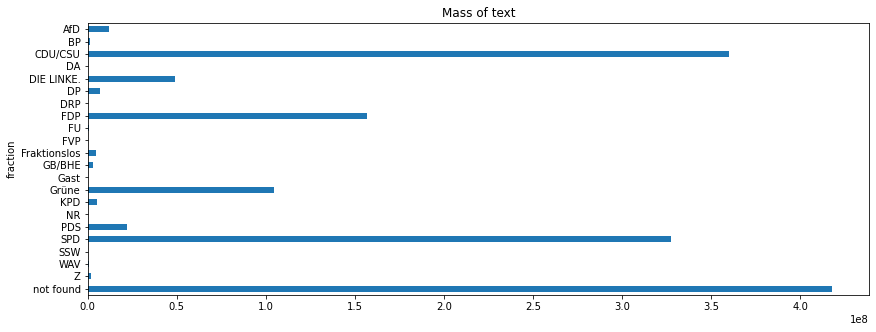

In [15]:
speeches_df[['fraction', 'speechLength']].groupby('fraction').sum().sort_index(ascending=False).plot.barh(title="Mass of text", legend=False)

Quite a few texts in "not found" fraction. This category contains also minister's speeches.

Future TODO: They could be mapped to their parties using information about the governing parties at the time.

Text(0.5, 0, 'Nth speech')

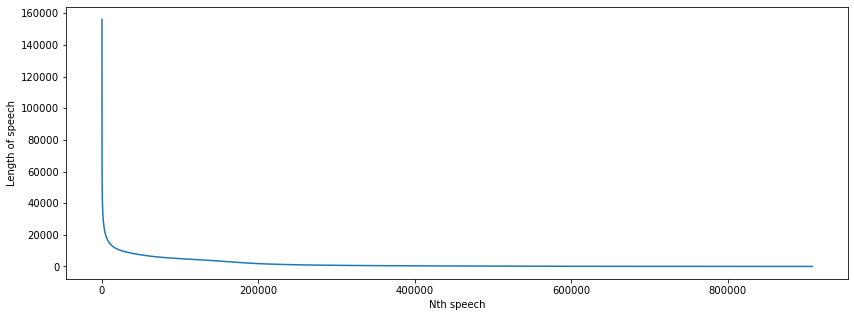

In [16]:
fig, ax = plt.subplots(figsize=(14,5))
speeches_df['speechLength'].sort_values(ascending=False).reset_index()['speechLength'][:].plot.line(ax=ax)
ax.set_ylabel('Length of speech')
ax.set_xlabel('Nth speech')

In [17]:
# longest_speech = speeches_df.sort_values(by='speechLength', ascending=False).iloc[0]['speechContent']

## Topic Modelling

### Preprocessing Pt. 1

- Load Documents
- Split into words
- Remove stop words, punctuation and other symbols.
- Lemmatization or Stemming

After that use topic modelling algorithm **LDA** available with gensim.

In [18]:
# STOP_WORDS_DE
# spacy.lang.de.stop_words.STOP_WORDS

In [19]:
nlp = spacy.load('de_core_news_lg') # install beforehand with: python -m spacy download de_core_news_lg

In [20]:
test_text = 'Hallo, ich bin ein Vorratsdatenspeicherer! \tDas ist ein Bindestrich-Wort.\r\nWäre das ein Satz, welcher gut klingt? Das sind zehntausend 123 und die 111. Möglichkeit.'

In [21]:
doc = nlp(test_text)
for t in doc:
    # Token Attributes: https://spacy.io/api/token
    print(f'lemma {repr(t.lemma_)}\t\t\tstopword "{t.is_stop}"\t\t\tpart-of-speech "{t.pos_}"')

lemma 'Hallo'			stopword "False"			part-of-speech "PART"
lemma ','			stopword "False"			part-of-speech "PUNCT"
lemma 'ich'			stopword "True"			part-of-speech "PRON"
lemma 'sein'			stopword "True"			part-of-speech "AUX"
lemma 'einen'			stopword "True"			part-of-speech "DET"
lemma 'Vorratsdatenspeicherer'			stopword "False"			part-of-speech "NOUN"
lemma '!'			stopword "False"			part-of-speech "PUNCT"
lemma '\t'			stopword "False"			part-of-speech "SPACE"
lemma 'der'			stopword "True"			part-of-speech "PRON"
lemma 'sein'			stopword "True"			part-of-speech "AUX"
lemma 'einen'			stopword "True"			part-of-speech "DET"
lemma 'Bindestrich-Wort'			stopword "False"			part-of-speech "NOUN"
lemma '.'			stopword "False"			part-of-speech "PUNCT"
lemma '\r\n'			stopword "False"			part-of-speech "SPACE"
lemma 'sein'			stopword "True"			part-of-speech "AUX"
lemma 'der'			stopword "True"			part-of-speech "PRON"
lemma 'einen'			stopword "True"			part-of-speech "DET"
lemma 'Satz'			stopword "False"			part

In [22]:
def preprocess_for_topic_modelling(texts):
    """texts : iterable of str (doc text)"""
    pos_blacklist = ('PUNCT','SYM','X','SPACE','NUM')
    pattern_digits = re.compile(r"\d+\.")
    
    for doc in nlp.pipe(texts, batch_size=50):
        r = []
        for token in doc:
            if (not token.is_stop
                and token.pos_ not in pos_blacklist
                and pattern_digits.fullmatch(token.lemma_) is None):
                r.append(token.lemma_)
        yield tuple(r)

In [23]:
list( preprocess_for_topic_modelling([test_text]) )

[('Hallo',
  'Vorratsdatenspeicherer',
  'Bindestrich-Wort',
  'Satz',
  'klingen',
  'Möglichkeit')]

In [24]:
for doc in preprocess_for_topic_modelling(speeches_df.speechContent):
    print(doc)
    break

('Dame', 'Herr', 'eröffnen', 'Sitzung', 'Bundestag', 'Tagesordnung', 'nunmehr', 'Eidesleistung', 'Herrn', 'Bundespräsidenten', 'schreiten', 'Artikel', 'Grundgesetzes', 'leisten', 'Herr', 'Bundespräsident', 'Amtsantritt', 'versammeln', 'Mitglied', 'Bundestag', 'Bundesrats', 'Eid', 'stelle', 'fest', 'Grund', 'Namensaufrufs', 'Mitglied', 'Bundestag', 'versammeln', 'Herr', 'Präsident', 'Bundesrats', 'fragen', 'Sinn', 'Artikel', 'Bundesrat', 'versammeln')


In [25]:
def transparent_iter(iterable, enabled=True):
    for count,item in enumerate(iterable):
        if enabled:
            clear_output()
            print(count)
        yield item

In [26]:
#speech_docs = pd.Series(data=preprocess_for_topic_modelling(speeches_df.speechContent),
#                        index=speeches_df.speechContent.index)

#docs = tuple(preprocess_for_topic_modelling(transparent_enumerate(speeches_df.speechContent)))

In [27]:
speeches_df.speechContent.shape

(907644,)

In [28]:
def dump_clean_speeches():
    with open('data/dump/dump_speeches_cleaned.json', 'w', encoding='ascii') as fp:
        for doc in preprocess_for_topic_modelling(transparent_iter(speeches_df.iloc[::-1].speechContent)):
            json.dump(doc,fp)
            fp.write('\n')

In [29]:
#dump_clean_speeches()

In [30]:
def add_speech_id(inpath='data/dump/dump_speeches_cleaned.json', outpath='data/dump/dump_speeches_cleaned_gen2.json'):
    with open(outpath, 'w', encoding='ascii') as out_file:
        with open(inpath, 'r', encoding='ascii') as in_file:
            for (i,line),id_speech in zip(enumerate(in_file),speeches_df.iloc[::-1].id_speech):
                doc = json.loads(line)
                obj = {'id_speech':id_speech ,'doc':doc}
                
                json.dump(obj,out_file)
                out_file.write('\n')

In [31]:
#add_speech_id()

### Preprocessing Pt. 2

Get term frequencies to find out data set specific stop words. E.g. "Herrn", "Kollegeinnen", "Präsident", "Artikel"

In [32]:
def get_termfrequencies(iterable_of_docs):
    term_frequencies = {}
    for doc in iterable_of_docs:
        for term in doc:
            if term in term_frequencies:
                term_frequencies[term] += 1
            else:
                term_frequencies[term] = 1
    return term_frequencies

In [33]:
def iter_jsonlines_file(fpath):
    with open(fpath, 'r', encoding='ascii') as in_file:
        for line in in_file:
            yield json.loads(line)

In [34]:
#tf = get_termfrequencies(iter_jsonlines_file('data/dump/dump_speeches_cleaned.json'))
#tfs = pd.Series(tf)
#list( tfs.sort_values(ascending=False).head(200).index )

### LDA

Using gensim: https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

Steps:

- Filter small documents (e.g. smaller than 10 tokens)
- Filter small tokens (1-2 characters)
- Convert to lowercase
- (Add bigrams)
- Remove rare and common tokens
- Vectorize (BOW style)
- LDA (Inspect, Visualize)

In [35]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#### Load docs and filter small ones

In [36]:
def iter_docs(fpath, exclude_doc_len=15, exclude_tok_len=2):
    """load docs from json lines and return generator of docs
    exclude_doc_len : int; exclude docs with less than given tokens
    exclude_tok_len : int; exclude tokens with less than given characters"""
    for i,obj in enumerate(iter_jsonlines_file(fpath)):
        doc = obj['doc']
        doc = [ token.lower() for token in doc if len(token)>=exclude_tok_len ]
        if len(doc) >= exclude_doc_len:
            yield doc

In [37]:
docs = list( iter_docs('data/dump/dump_speeches_cleaned_gen2.json') )

In [38]:
len(docs), max((len(doc) for doc in docs))

(486612, 12515)

In [39]:
docs[0][:5]

['frau', 'präsidentin', 'lieben', 'kollegin', 'kollege']

#### Add bigrams

In [40]:
from gensim.models import Phrases

In [41]:
# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

2021-06-09 17:42:11,160 : INFO : collecting all words and their counts
2021-06-09 17:42:11,161 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2021-06-09 17:42:14,345 : INFO : PROGRESS: at sentence #10000, processed 1734090 words and 1266156 word types
2021-06-09 17:42:17,859 : INFO : PROGRESS: at sentence #20000, processed 3514061 words and 2288265 word types
2021-06-09 17:42:21,411 : INFO : PROGRESS: at sentence #30000, processed 5271878 words and 3179713 word types
2021-06-09 17:42:25,196 : INFO : PROGRESS: at sentence #40000, processed 7226238 words and 4047188 word types
2021-06-09 17:42:29,161 : INFO : PROGRESS: at sentence #50000, processed 9171587 words and 4872167 word types
2021-06-09 17:42:34,040 : INFO : PROGRESS: at sentence #60000, processed 11238463 words and 5636484 word types
2021-06-09 17:42:38,823 : INFO : PROGRESS: at sentence #70000, processed 13293749 words and 6474485 word types
2021-06-09 17:42:42,583 : INFO : PROGRESS: at sentence #80000, 

In [53]:
docs[0][-5:]

['aktuelle_stunde',
 'hass_hetze',
 'unwahrheiten_verbreiten',
 'sinn_wünsche',
 'schön_wochenend']

#### Build dictionary and remove rare and common tokens

In [54]:
from gensim.corpora import Dictionary

In [55]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

2021-06-09 17:58:01,050 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-06-09 17:58:04,030 : INFO : adding document #10000 to Dictionary(123091 unique tokens: ['abschließend', 'absurd', 'act', 'afd', 'aktionsplan']...)
2021-06-09 17:58:07,181 : INFO : adding document #20000 to Dictionary(180760 unique tokens: ['abschließend', 'absurd', 'act', 'afd', 'aktionsplan']...)
2021-06-09 17:58:10,383 : INFO : adding document #30000 to Dictionary(222576 unique tokens: ['abschließend', 'absurd', 'act', 'afd', 'aktionsplan']...)
2021-06-09 17:58:13,721 : INFO : adding document #40000 to Dictionary(265305 unique tokens: ['abschließend', 'absurd', 'act', 'afd', 'aktionsplan']...)
2021-06-09 17:58:17,291 : INFO : adding document #50000 to Dictionary(301912 unique tokens: ['abschließend', 'absurd', 'act', 'afd', 'aktionsplan']...)
2021-06-09 17:58:20,766 : INFO : adding document #60000 to Dictionary(333153 unique tokens: ['abschließend', 'absurd', 'act', 'afd', 'aktionsplan']...)
2

In [56]:
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

2021-06-09 18:00:30,460 : INFO : discarding 1117476 tokens: [('anke_domscheit-berg', 22), ('benutzergruppen', 11), ('digital_service', 23), ('domscheit-berg', 33), ('echokammern', 13), ('facebook-accounts', 4), ('forschungsklausel', 6), ('handlangern', 33), ('herr', 357170), ('jugendschutzvorschriften', 13)]...
2021-06-09 18:00:30,461 : INFO : keeping 100000 tokens which were in no less than 20 and no more than 243306 (=50.0%) documents
2021-06-09 18:00:31,275 : INFO : resulting dictionary: Dictionary(100000 unique tokens: ['abschließend', 'absurd', 'act', 'afd', 'aktionsplan']...)


#### Bag-of-words representation of the documents.

In [57]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

#### Train LDA model

In [58]:
from gensim.models import LdaModel

In [ ]:
# Set training parameters.
num_topics = 50
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

2021-06-09 18:09:07,729 : INFO : using autotuned alpha, starting with [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
2021-06-09 18:09:07,753 : INFO : using serial LDA version on this node
2021-06-09 18:09:08,313 : INFO : running online (multi-pass) LDA training, 50 topics, 20 passes over the supplied corpus of 486612 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2021-06-09 18:09:08,315 : INFO : PROGRESS: pass 0, at document #2000/486612
2021-06-09 18:09:25,260 : INFO : optimized alpha [0.018407568, 0.018021867, 0.018539805, 0.018296955, 0.018408002, 0.018904282, 0.019099286, 0.018231481, 0.018673284, 0.018297922, 0.018187938, 0.019719

In [ ]:
model.save('data/dump/lda_model_50_topics')